

# Generating Shakespeare with a Character-Level RNN


In this part, we'll turn from traditional n-gram based language models to a more advanced form of language modeling using a Recurrent Neural Network. Specifically, we'll be setting up a character-level recurrent neural network (char-rnn) for short.

Andrej Karpathy, a researcher at OpenAI, has written an excellent blog post about using RNNs for language models, which you should read before beginning this assignment.  The title of his blog post is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

Karpathy shows how char-rnns can be used to generate texts for several fun domains:
* Shakespeare plays
* Essays about economics
* LaTeX documents
* Linux source code
* Baby names

<div class="alert alert-info" markdown="1">
Here are the materials that you should download for this assignment:

* [training data and devlopment data for generation](https://www.cc.gatech.edu/classes/AY2020/cs7650_spring/hw3/lm/data.zip).
</div>

# Recommended Reading

You should install PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

## You can also set up Pytorch in Google Colab

Pytorch is one of the most popular deep learning frameworks in both industry and academia, and learning its use will be invaluable should you choose a career in deep learning. 

### Setup
#### Using Google Colab (recommended)
1. Upload this notebook on [Colab](https://colab.research.google.com/notebooks/welcome.ipynb).
2. Set hardware accelerator to ```GPU``` under ```notebook settings``` in the ```Edit``` menu.
3. Run the first cell to  set up  the environment.

### Note
Please look at the FAQ section before you start working.


# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [1]:
! pip install unidecode

     |████████████████████████████████| 245kB 9.3MB/s 


In [29]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('sample_data/shakespeare_input.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4573338


To make inputs out of this big string of data, we will be splitting it into chunks.

In [30]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

arted from you
He left a promise to return again
Within an hour, and pacing through the forest,
Chewing the food of sweet and bitter fancy,
Lo, what befell! he threw his eye aside,
And mark what object


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution. You need to finish the forward method. (Refer to [Pytorch GRU Documentation](https://pytorch.org/docs/stable/nn.html#gru))

In [0]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        #Input input: torch Tensor of shape (1,)
        #hidden: torch Tensor of shape (self.n_layers, 1, self.hidden_size)
        #Return output: torch Tensor of shape (1, self.output_size) 
        #and hidden: torch Tensor of shape (self.n_layers, 1, self.hidden_size)
        #combined = torch.cat((input,hidden),1)
        #print(input)
        #print(hidden)
        encode = self.encoder(input.view(1,-1))
        output, hidden = self.gru(encode.view(1,1,-1),hidden) 
        output = self.decoder(output.view(1,-1))
        return output, hidden       
        

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [38]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long().to(device)
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41], device='cuda:0')


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target.unsqueeze(1)[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [68]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 4
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #print(*random_training_set())
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 33s (100 5%) 3.5504]
Wh asah Eet dsC   mb rw yu  dwl s l; w
 is aoo adls n hhinT A p ln od atieAcis, thah rse Hh duustox, o 

 6s (200 10%) 3.1104]
Whtasht dot stgee ad dfonivil ooge

sse tard sbd:ro mutk ce ebhluwus te ban ehuy hou hawunn ot bfhut t 

 39s (300 15%) 2.5172]
Whis set con ca ad dudive anse hesiepset hor stet  ote yent ceteut wik ant me tesh meln to.
I!
Mvad si 

 13s (400 20%) 2.5111]
Whve woemint, sine.

AREO:
Coriid wuuned wons
wiw wavat he sattilst mhit she bu nhy to lauwk.

SO:
I t 

 46s (500 25%) 2.4379]
Whove qondseg in mord.

BALEYNFLKLN:
Fiub wardice. Thikcee moghe nrraiwe coluny fo alge be the athe, l 

 20s (600 30%) 2.6415]
Whis the math the am fraee dorge I my ale lare igth, hercarge hir fire

Aus:
Biny thase thaurs'le the  

 54s (700 35%) 2.2424]
Where.

ISAURO:
So the noth thald the us, doke thit ejrer a.

SEVACES:
With ance thinll bet nas thse t 

 28s (800 40%) 2.0867]
Whtous hour haves shimt youve me fome thouf to louw to in Momees, whow I and be?

S

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

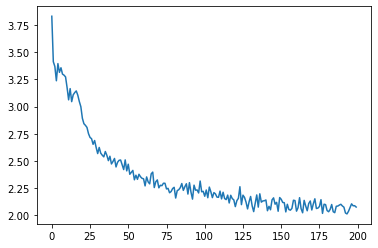

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [70]:
print(evaluate('Th', 200, temperature=0.8))

The put of enter withing the hir: and awlead with to like with the if theaw withand a for thut thear which in of the the catter riclatind,
What his the more, and he be this sute to the prittizean: Far M


Lower temperatures are less varied, choosing only the more probable outputs:

In [71]:
print(evaluate('Th', 200, temperature=0.2))

This the propes the the prite the compon the lord have the like the have the how the propes his pain the lord the proped the propell the lord the for her the propes have the his deal the light the her t


Higher temperatures more varied, choosing less probable outputs:

In [72]:
print(evaluate('Th', 200, temperature=1.4))

Thizibppuicodlalt hiss ontiom,
Enalw
, will; caver! ghisfarpj his hlil alub, 'pomorm, herd?, Gepvest
Sits, O owf, sisters: Auis, Crevefry a hlest alafrooce Rew:, apigail, Cou, Gedtegd
Ank have rudonsail


In [73]:
import torch.nn.functional as F
def perp(testfile):
    inp = char_tensor(testfile[:-1])
    target = char_tensor(testfile[1:])
    test_len=len(testfile)
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    perplexity=torch.tensor(0.0)

    for c in range(test_len-1):
        output, hidden = decoder(inp[c], hidden)
        perplexity -=F.log_softmax(output,dim=1)[0][target[c]]

    return (perplexity/test_len).item()

testfile = unidecode.unidecode(open('sample_data/shakespeare_sonnets.txt').read())
print('Perplexity:',perp(testfile))

Perplexity: 2.125791072845459


## FAQs

#### I'm unfamiliar with PyTorch. How do I get started?
If you are new to the paradigm of computational graphs and functional programming, please have a look at this [tutorial](https://hackernoon.com/linear-regression-in-x-minutes-using-pytorch-8eec49f6a0e2) before getting started.

#### How do I speed up training?
Send the model and the input, output tensors to the GPU using ```.to(device)```. Refer the [PyTorch docs](https://pytorch.org/docs/stable/notes/cuda.html) for further information.
